# Time series forecasting fundamentals with TensorFlow + Milestone Project 3: BitPredict

**Note:** This is not financial advice.

Let's write some TensorFlow code to predict the price of Bitcoin based on the historical price of Bitcoin.

## Get Data

We're going to be using the historical price data of Bitcoin to try and predict the future price of Bitcoin, we download the data from here:  

In [4]:
from google.colab import files

uploaded = files.upload()

Saving bitcoin_2010-07-17_2023-10-15.csv to bitcoin_2010-07-17_2023-10-15.csv


## Importing time series with pandas

In [5]:
# Import with pandas
import pandas as pd
import io
# Let's read in our Bitcoin data and parse the dates
df = pd.read_csv(io.BytesIO(uploaded['bitcoin_2010-07-17_2023-10-15.csv']),
                 parse_dates=["Start"],
                 index_col=["Start"]) # parse the date column and tell pandas column 1 is a date time

df.head()

,End,Open,High,Low,Close,Volume,Market Cap
Start,,,,,,,
2023-10-14,2023-10-15,26881.55,26968.05,26807.54,26858.70,2.947480e+10,5.245552e+11
2023-10-13,2023-10-14,26758.71,27055.95,26697.05,26841.72,2.900574e+10,5.232913e+11
2023-10-12,2023-10-13,26849.32,26928.73,26577.40,26738.45,2.718705e+10,5.222412e+11
2023-10-11,2023-10-12,27400.04,27467.70,26548.13,26844.46,2.620682e+10,5.270596e+11
2023-10-10,2023-10-11,27591.37,27707.75,27302.72,27390.34,2.571702e+10,5.369620e+11


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4838 entries, 2023-10-14 to 2010-07-17
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   End         4838 non-null   object 
 1   Open        4838 non-null   float64
 2   High        4838 non-null   float64
 3   Low         4838 non-null   float64
 4   Close       4838 non-null   float64
 5   Volume      4838 non-null   float64
 6   Market Cap  4838 non-null   float64
dtypes: float64(6), object(1)
memory usage: 302.4+ KB


In [7]:
# How many samples do we have
len(df)

4838

**Note:** The **seasonality** of a time series dataset is referred as the number of samples per year. So for our Bitcoin data, it has a seasonality of daily or value of 365 because we collect one sample per day meaning we'll get 365 samples per year.

In [8]:
df.head()

,End,Open,High,Low,Close,Volume,Market Cap
Start,,,,,,,
2023-10-14,2023-10-15,26881.55,26968.05,26807.54,26858.70,2.947480e+10,5.245552e+11
2023-10-13,2023-10-14,26758.71,27055.95,26697.05,26841.72,2.900574e+10,5.232913e+11
2023-10-12,2023-10-13,26849.32,26928.73,26577.40,26738.45,2.718705e+10,5.222412e+11
2023-10-11,2023-10-12,27400.04,27467.70,26548.13,26844.46,2.620682e+10,5.270596e+11
2023-10-10,2023-10-11,27591.37,27707.75,27302.72,27390.34,2.571702e+10,5.369620e+11


In [9]:
# Only want closing price for each day
bitcoin_prices = pd.DataFrame(df["Close"]).rename(columns={"Close": "Price"})
bitcoin_prices

,Price
Start,
2023-10-14,26858.7000
2023-10-13,26841.7200
2023-10-12,26738.4500
2023-10-11,26844.4600
2023-10-10,27390.3400
...,...
2010-07-21,0.0792
2010-07-20,0.0747
2010-07-19,0.0808


Text(0.5, 1.0, 'Price of Bitcoin from 6 Aug 2018 to 4 Aug 2023')

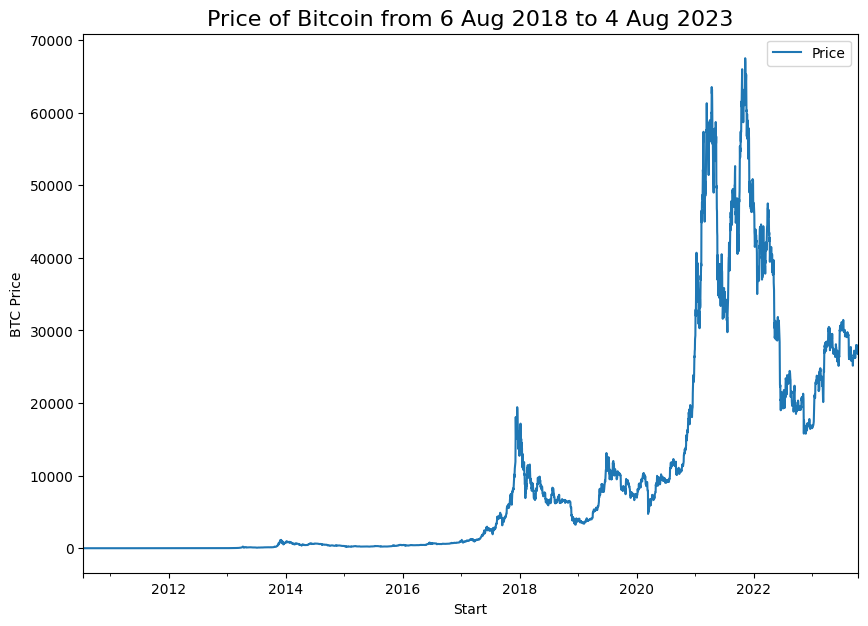

In [10]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 6 Aug 2018 to 4 Aug 2023", fontsize=16)

## Format data part 1: Create train and test sets of our time series data

### Creating train and test sets with time series data (the wrong way)

In [11]:
# get bitcoin data array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2023-10-14T00:00:00.000000000', '2023-10-13T00:00:00.000000000',
        '2023-10-12T00:00:00.000000000', '2023-10-11T00:00:00.000000000',
        '2023-10-10T00:00:00.000000000', '2023-10-09T00:00:00.000000000',
        '2023-10-08T00:00:00.000000000', '2023-10-07T00:00:00.000000000',
        '2023-10-06T00:00:00.000000000', '2023-10-05T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([26858.7 , 26841.72, 26738.45, 26844.46, 27390.34, 27584.1 ,
        27932.44, 27958.62, 27933.  , 27422.6 ]))

In [12]:
# Wrong way to make train/test sets for time series data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(timesteps, # dates
                                                    prices, # BTC prices
                                                    test_size=0.2,
                                                    random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape
# It's wrong because data splits randomly

((3870,), (968,), (3870,), (968,))

### Create train & test sets for time series (the right way)

In [13]:
# Create train and test splits the right way for time series data
split_size = int(0.1 * len(prices)) # 80% train, 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[split_size:], prices[split_size:]

# Create test data splits (everything beyond the split)
X_test, y_test = timesteps[:split_size], prices[:split_size]

len(X_train), len(X_test), len(y_train), len(y_test)

(4355, 483, 4355, 483)

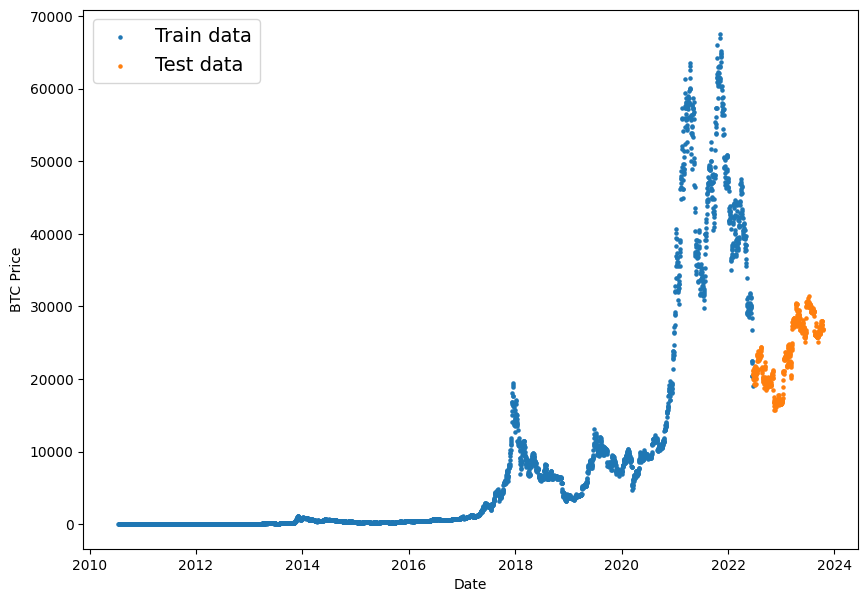

In [14]:
# Plot correctly made splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

## Create a plotting function

Typing plotting code is tedious, let's functionize it.

In [15]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format="dotted", start=0, end=None, label=None):
  """
  Plots timesteps (a series of points in time) against values (a series of values across timesteps).

  Parameters
  ----------
  timesteps : array of timesteps values
  values: array of values across time
  format: style of plot, default "."
  start: where to start the plot
  end: where to end the plot
  label: label to show on plot about values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], linestyle=format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)


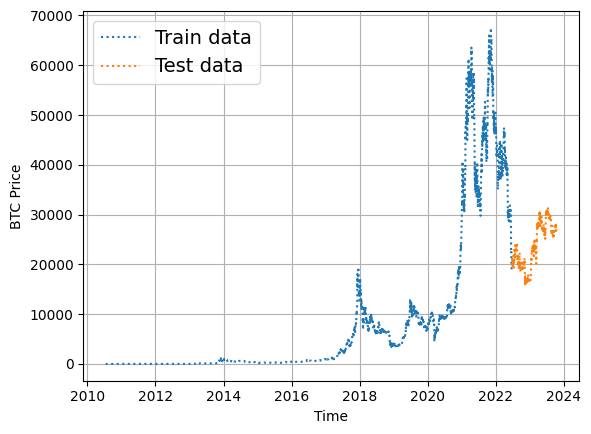

In [16]:
# Test put plotting function
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

## Modelling  Experiments

We've got some Bitcoin historical data, to model it, let's run a series of modelling experiments and see which model performs best.

Terms to be familiar with:
* **Horizon: ** number of timesteps into the fucture we're going to predict.
* **Window size: ** number of timesteps we're going to use to predict horizon

Modelling experiments we're running:
0. Naive model (baseline)
1. Dense model, horizon = 1, window = 7
2. Same as 1, horizon = 1, window = 30
3. Same as 1, horizon = 7, window = 30
4. Conv1D, horizon = 1, window = 7
5. LSTM, horizon = 1, window = 7
6. Same as 1 (but with multivariate data)
7. N-BEATs Algorithm
8. Ensemble (multiple models optimized on different loss functions)
9. Future prediction model (model to predict future values)
10. Same as 1 (but with turky data introduced)

## Model 0: Naive forecast (basleine)

The formula looks like:

$$\hat{y}_{t} = y_{t-1}$$

In English:
> The prediction at timestep t (y-hat) is equal to the value at timestep t-1 (previous timestep) - this is for a horizon of 1.

In [17]:
# Create a Naive forecast
naive_forecast = y_test[:-1]

naive_forecast[:10], naive_forecast[-10:]

(array([26858.7 , 26841.72, 26738.45, 26844.46, 27390.34, 27584.1 ,
        27932.44, 27958.62, 27933.  , 27422.6 ]),
 array([20101.12      , 20293.4508    , 20732.9834    , 21029.2163    ,
        21499.97103713, 21279.53232918, 21075.1688    , 19976.05359135,
        20739.94338572, 20672.8011    ]))

In [18]:
y_test[-10:]

array([20293.4508    , 20732.9834    , 21029.2163    , 21499.97103713,
       21279.53232918, 21075.1688    , 19976.05359135, 20739.94338572,
       20672.8011    , 20554.9027    ])

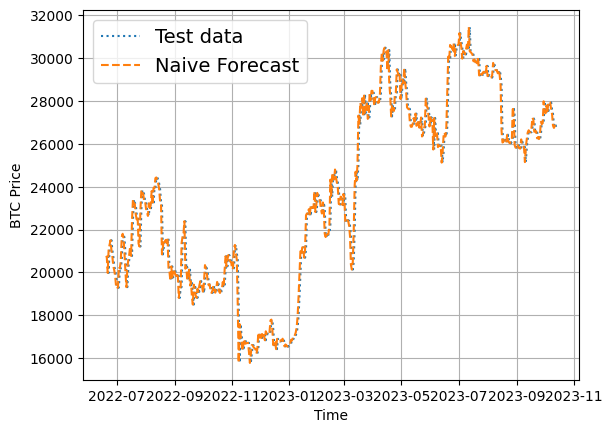

In [19]:
# plot naive forecast
# plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="dashed", label="Naive Forecast")

## Evaluating a time series model

Let's look into some evaluation metrics for time series forecasting.

What are we doing?

We're predicting a number, so that means we have a form of a regression problem.

Because we're working on a regression problem, we'll need some regression-like metrics.

A few comman regression metrics (which can also be used for time series forecasting):
* MAE - mean absolute error
* MSE - mean squared error
* RMSE - root mean squared error
* MAPE/sMAPE - (symmetric) mean absolute percentage error
* MASE - mean absolute scaled error

For all of the above metrics, **lower is better**, for example, an MAE of 0 that is better than an MAE of 100.

The main thing we're evaluating here is: **how do our model's forecasts (y_pred) compare against the actual values(y_true or ground truth values)?**

In [20]:
import tensorflow as tf

In [21]:
# MASE implementation
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (Assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true-y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shift of 1)

  return mae / mae_naive_no_season

In [22]:
mean_absolute_scaled_error(y_true=y_test[1:], y_pred=naive_forecast).numpy()

0.9980167746957285

In [23]:
# Create a function to take in model predictions and truth values and return evaluation metrics
def evaluate_preds(y_true, y_pred):
  # Make sure float32 datatypes (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various evaluation metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "mape": mape.numpy(),
          "rmse": mape.numpy(),
          "mase": mase.numpy(),}


In [24]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)

naive_results

{'mae': 384.3977,
 'mse': 335558.1,
 'mape': 1.6684074,
 'rmse': 1.6684074,
 'mase': 0.99801695}

In [25]:
naive_forecast[-10:]

array([20101.12      , 20293.4508    , 20732.9834    , 21029.2163    ,
       21499.97103713, 21279.53232918, 21075.1688    , 19976.05359135,
       20739.94338572, 20672.8011    ])

In [26]:
tf.reduce_mean(y_test)

<tf.Tensor: shape=(), dtype=float64, numpy=23685.870578827602>

In [27]:
tf.reduce_min(y_test), tf.reduce_max(y_test)

(<tf.Tensor: shape=(), dtype=float64, numpy=15779.971701749892>,
 <tf.Tensor: shape=(), dtype=float64, numpy=31446.3>)

## Other models we can use for baseline and for actual forecasts

In this notebook, we're focused on TensorFlow and deep learning models.

However there are plenty of other styles of time series forecasting models we may want to experiment with.

## Format Data Part2: Windowing our dataset

Why do we window?
We window our time series dataset to turn our data into a supervised learning problem.

```
Windowing for one week
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

In [33]:
# What we want to do with our Bitocin data
print(f"We want to use: {prices[:7]} to predict this: {prices[7]}")

We want to use: [26858.7  26841.72 26738.45 26844.46 27390.34 27584.1  27932.44] to predict this: 27958.62


In [29]:
# Let's setup global variables for window and horizon size
HORIZON = 1 # predict next 1 day
WINDOW_SIZE = 7 # use the past week of Bitcoin data to make the predcition

In [30]:
# Create function to label windowed data
def get_labelled_window(x, horizon=HORIZON):
  """
  Create labels for windowed dataset.

  E.g. if horizon=1
  Input: [0, 1, 2, 3, 4, 5, 6, 7] -> Output: ([0, 1, 2, 3, 4, 5, 6], [7])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [31]:
# Test out the window labelling function
test_window, test_label = get_labelled_window(tf.expand_dims(tf.range(8)+1, axis=0))
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


In [32]:
prices

array([2.685870e+04, 2.684172e+04, 2.673845e+04, ..., 8.080000e-02,
       8.580000e-02, 5.000000e-02])